In [1]:
import os
import cv2
import torch as T
from torch.utils.data import Dataset, DataLoader
import numpy as np
from glob import glob
import re
import torch.nn as nn
import timm
import torch.nn.functional as F
from kmeans_pytorch import kmeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time
import sys
from contextlib import contextmanager

In [2]:
BASE_PATH = r"D:\AAU Internship\Code\CWF-788\IMAGE512x384"
DEVICE = T.device("cuda" if T.cuda.is_available() else "cpu")
print(f"🚀 Using device: {DEVICE}")

🚀 Using device: cuda


In [3]:
class CropWeedDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = glob(os.path.join(folder_path, "*.jpg"))
        self.image_paths += glob(os.path.join(folder_path, "*.png"))

        def natural_key(string):
            return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string)]

        self.image_paths.sort(key=natural_key)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img_tensor = T.from_numpy(img).permute(2, 0, 1).contiguous()

        return img_tensor.to(DEVICE), img_path

def get_loader(folder_path, batch_size=4):
    dataset = CropWeedDataset(folder_path)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

train_path = os.path.join(BASE_PATH, "train_new")
val_path   = os.path.join(BASE_PATH, "validation_new")
test_path  = os.path.join(BASE_PATH, "test_new")
train_loader = get_loader(train_path)
val_loader   = get_loader(val_path)
test_loader  = get_loader(test_path)

In [4]:
def compute_fused_contours(batch_imgs):
    T.cuda.empty_cache()
    fused_maps = []
    batch_imgs_np = batch_imgs.detach().cpu().numpy()

    for img in batch_imgs_np:
        img_rgb = np.transpose(img, (1, 2, 0)) * 255.0
        img_rgb = img_rgb.astype(np.uint8)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        # Sobel
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = cv2.magnitude(sobelx, sobely)
        sobel = np.clip(sobel / sobel.max(), 0, 1)

        # Canny
        canny = cv2.Canny(gray, 100, 200) / 255.0

        # Fuse Sobel + Canny
        fused = np.maximum(sobel, canny)

        fused_tensor = T.tensor(fused, dtype=T.float32).unsqueeze(0)
        fused_maps.append(fused_tensor)

    fused_batch = T.stack(fused_maps).to(batch_imgs.device)
    T.cuda.empty_cache()
    return fused_batch

In [5]:
class HRNetW32FeatureExtractor(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.backbone = timm.create_model(
            "hrnet_w32", 
            pretrained=True, 
            features_only=True
        ).to(self.device)

        # HRNet returns multi-scale outputs (C1, C2, C3, C4)
        # We'll use the highest-resolution one: index 0
        self.selected_feature_idx = 0

        # Freeze the backbone
        self.backbone.eval()

    def forward(self, x):
        with T.no_grad():
            features = self.backbone(x)  # List of [B, C, H', W']
            feature_map = features[self.selected_feature_idx]  # [B, 32, 96, 128]

            # Upsample to match original input size (384×512)
            feature_map_upsampled = F.interpolate(
                feature_map,
                size=(384, 512),
                mode='bicubic',  # Better edge preservation
                align_corners=False
            )

            return feature_map_upsampled  # [B, 32, 384, 512]


In [6]:
class ContourFeatureFusion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_fusion = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, cnn_features, edge_maps):
        # cnn_features: [B, C1, H, W]
        # edge_maps:    [B, 1, H, W]
        x = T.cat([cnn_features, edge_maps], dim=1)  # [B, C1+1, H, W]
        fused = self.conv_fusion(x)
        return fused


In [7]:
def segment_kmeans(fused_features, n_clusters=2):
    masks = []
    fused_np = fused_features.detach().cpu().numpy()

    for feat in tqdm(fused_np, desc="🧠 Running K-Means on batch"):
        C, H, W = feat.shape
        flat_feat = feat.reshape(C, -1).T

        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        labels = kmeans.fit_predict(flat_feat)

        mask = labels.reshape(H, W)
        masks.append(mask.astype(np.uint8))

    return masks


In [8]:
def refine_mask(mask, apply_opening=True, apply_closing=True, dilate=False):
    kernel = np.ones((5, 5), np.uint8)

    if apply_opening:
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if apply_closing:
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    if dilate:
        mask = cv2.dilate(mask, kernel, iterations=1)

    return mask


@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr


def process_kmeans_with_centroids(fused_tensor, n_clusters=2):
    C, H, W = fused_tensor.shape
    flat_feat = fused_tensor.view(C, -1).T.contiguous().to(DEVICE)

    with suppress_stdout_stderr():
        labels, cluster_centers = kmeans(
            X=flat_feat,
            num_clusters=n_clusters,
            distance='euclidean',
            device=DEVICE
        )


    labels_np = labels.cpu().numpy()
    centers_np = cluster_centers.cpu().numpy()

    fg_label = np.argmin(centers_np.mean(axis=1))
    mask = (labels_np == fg_label).astype(np.uint8).reshape(H, W)

    return refine_mask(mask)


def batch_process_kmeans_masks(fused_features):
    fused_np = fused_features.detach()  # Already on GPU
    final_masks = []

    for feat in tqdm(fused_np, desc="🧠 Step 6: Refining Masks (GPU KMeans)", leave=False):
        refined_mask = process_kmeans_with_centroids(feat)
        final_masks.append(refined_mask)

    return final_masks


In [9]:
def batch_infer_masks(data_loader, model, device):
    model.eval()
    final_masks_all = []
    image_paths_all = []
    total_time = 0
    total_images = 0

    for batch_imgs, paths in tqdm(data_loader, desc="📦 Step 7: Batch Inference", leave=True):
        batch_imgs = batch_imgs.to(device)
        start_time = time.time()

        with T.no_grad():
            # Step 3: Feature extraction from RGB only
            cnn_feats = model(batch_imgs)

            # Step 2: Contour extraction from RGB
            contour_maps = compute_fused_contours(batch_imgs)

            # Step 4: Fuse CNN + Contours
            fusion_module = ContourFeatureFusion(cnn_feats.shape[1] + 1, cnn_feats.shape[1]).to(device)
            fused_features = fusion_module(cnn_feats, contour_maps)

            # Step 5-6: Generate & refine masks
            masks = batch_process_kmeans_masks(fused_features)

        end_time = time.time()

        batch_time = end_time - start_time
        total_time += batch_time
        total_images += len(batch_imgs)

        final_masks_all.extend(masks)
        image_paths_all.extend(paths)

    avg_time_ms = (total_time / total_images) * 1000
    print(f"🕒 Average Processing Time: {avg_time_ms:.2f} ms/image")

    return final_masks_all, image_paths_all


In [10]:
def save_masks_and_overlay(masks, paths, split_name, save_root="Vegetation Masks"):
    """
    Save binary masks (0/255) to disk and return sample list for visualization.
    """
    os.makedirs(save_root, exist_ok=True)
    save_dir = os.path.join(save_root, split_name)
    os.makedirs(save_dir, exist_ok=True)

    overlay_candidates = []

    for mask, path in zip(masks, paths):
        # Extract image filename
        filename = os.path.basename(path)
        filename = os.path.splitext(filename)[0] + ".png"  # Save all as .png

        save_path = os.path.join(save_dir, filename)

        # Convert mask to uint8: values 0 and 255
        mask_uint8 = (mask * 255).astype(np.uint8)
        cv2.imwrite(save_path, mask_uint8)

        # Save for potential overlay
        overlay_candidates.append((path, mask_uint8))

    print(f"✅ Saved {len(masks)} masks to '{save_dir}'")
    return overlay_candidates


def show_random_overlay(sample_list, overlay_color=(0, 255, 0)):
    """
    Visualize one overlayed mask on top of original RGB image.
    """
    img_path, mask = random.choice(sample_list)

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize mask if needed
    if mask.shape != img.shape[:2]:
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply colored overlay
    overlay = img.copy()
    overlay[mask == 255] = overlay_color

    # Blend original + overlay
    blended = cv2.addWeighted(img, 0.4, overlay, 0.6, 0)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title("Overlayed Vegetation Mask")
    plt.imshow(blended)
    plt.axis('off')
    plt.show()


Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


📦 Step 7: Batch Inference:   0%|          | 0/400 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🕒 Average Processing Time: 1356.09 ms/image


📦 Step 7: Batch Inference:   0%|          | 0/88 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🕒 Average Processing Time: 1411.51 ms/image


📦 Step 7: Batch Inference:   0%|          | 0/300 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🧠 Step 6: Refining Masks (GPU KMeans):   0%|          | 0/4 [00:00<?, ?it/s]

🕒 Average Processing Time: 1365.35 ms/image
✅ Saved 1600 masks to 'Vegetation Masks\train'
✅ Saved 352 masks to 'Vegetation Masks\val'
✅ Saved 1200 masks to 'Vegetation Masks\test'


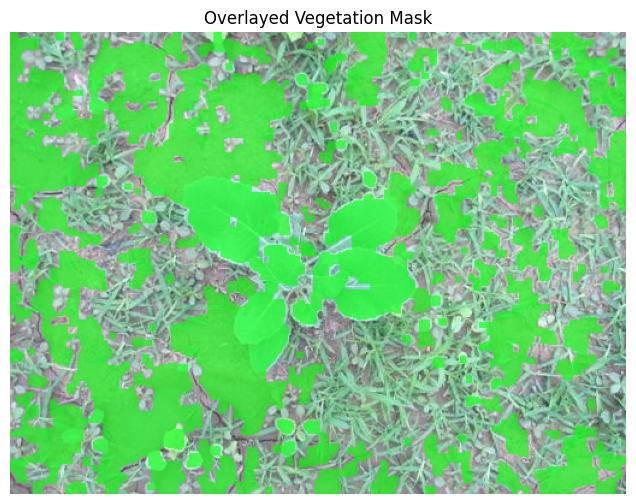

In [11]:
# 🔁 Instantiate the feature extractor (Step 3)
feature_extractor = HRNetW32FeatureExtractor(device=DEVICE)

# 🔄 Run batch inference for all 3 splits
train_masks, train_paths = batch_infer_masks(train_loader, feature_extractor, DEVICE)
val_masks, val_paths     = batch_infer_masks(val_loader, feature_extractor, DEVICE)
test_masks, test_paths   = batch_infer_masks(test_loader, feature_extractor, DEVICE)

# 💾 Save masks and prepare overlays (Step 8)
train_samples = save_masks_and_overlay(train_masks, train_paths, "train")
val_samples   = save_masks_and_overlay(val_masks, val_paths, "val")
test_samples  = save_masks_and_overlay(test_masks, test_paths, "test")

show_random_overlay(val_samples)


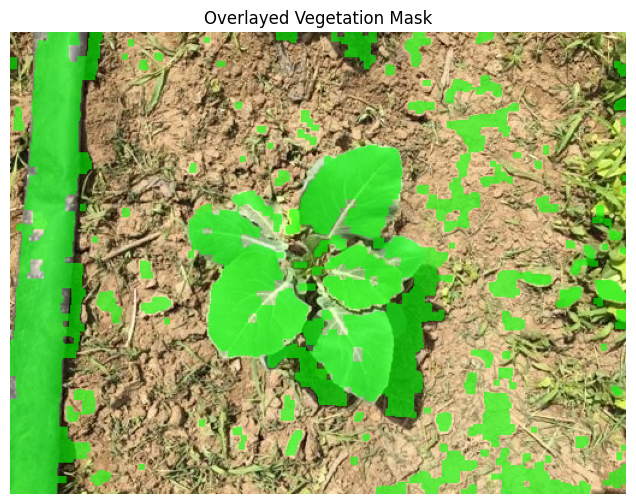

In [12]:
show_random_overlay(val_samples)